In [1]:
import pandas
import datetime
import numpy
from sklearn import linear_model
import scipy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.
probOccCutoff = 0.2

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velGmagDF = velGmagDF[ (velGmagDF["vSaps"] > velCutoffLower) \
                        & (velGmagDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velGmagDF = velGmagDF[ velGmagDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
# Now filter out velocities which have very few rate of occ.
# We calculat the prob and remove every measurement below 0.2 prob of occ.
mlatMLTDstCountDF = velGmagDF.groupby( ["MLAT", "normMLT", "dst_bin"] )["vSaps"].count().reset_index()
mlatMLTDstCountDF.columns = [ "MLAT", "normMLT", "dst_bin", "count" ]
dstMaxCntDF = mlatMLTDstCountDF.groupby( ["dst_bin"] )["count"].max().reset_index()
dstMaxCntDF.columns = [ "dst_bin", "maxCntDst" ]
mlatMLTDstCountDF = pandas.merge( mlatMLTDstCountDF, dstMaxCntDF, on=[ "dst_bin" ] )
mlatMLTDstCountDF["probOcc"] = mlatMLTDstCountDF["count"]/mlatMLTDstCountDF["maxCntDst"]
mlatMLTDstCountDF = mlatMLTDstCountDF[ mlatMLTDstCountDF["probOcc"] > probOccCutoff ].reset_index(drop=True)
# Filter out MLATs and MLTs (at the Dst bins)
# where number of measurements is low. We do
# this by merging the mlatMLTDstCountDF with velDF.
velGmagDF = pandas.merge( velGmagDF,\
                         mlatMLTDstCountDF,\
                         on=[ "MLAT", "normMLT", "dst_bin" ] )
velGmagDF = velGmagDF[ [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count", "maxCntDst" ] ]
# Divide the velocities into bins
velBins = [ v for v in range(0,int(velCutoffUpper)+100,100) ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["vSaps"], \
                               bins=velBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count",\
                         "maxCntDst", "vel_bin" ]
# velGmagDF.head()
# Get a DF with mean Dst in each bin
dstMeanDF = velGmagDF.groupby( ["dst_bin"] ).mean()["dst_index"].astype(int).reset_index()
dstMeanDF.columns = [ "dst_bin", "dst_mean" ]
velGmagDF = pandas.merge( velGmagDF, dstMeanDF, on=["dst_bin"] )
velGmagDF = velGmagDF.sort( ["dst_mean"], ascending=False ).reset_index(drop=True)
# velGmagDF.head()
velGmagDF["dst_bin"].unique()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


array(['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-75, -50]', '(-150, -75]'], dtype=object)

In [4]:
# read data from the lshell file
fitRlgDF = pandas.read_csv("../data/fit-rayleigh.txt", sep=' ')
fitRlgDF.head()

,dst_bin,dst_mean,loc,mlat,norm_mlt,scale,shape
0,"(-10, 10]",-3,117.780819,58.0,1.0,291.382849,0.0
1,"(-25, -10]",-17,75.631906,58.0,1.0,371.032765,0.0
2,"(-50, -25]",-36,121.737946,58.0,1.0,338.189065,0.0
3,"(-10, 10]",-3,192.860564,61.0,1.0,314.230608,0.0
4,"(-25, -10]",-17,181.518228,61.0,1.0,265.956916,0.0


In [5]:
# Now we fit loc, scale and shape as a function of MLAT, MLT and Dst
def scale_fit_func((mlt,mlat, dst), a_ascmlt, b_ascmlt, a_bscmlt, b_bscmlt, a_cscmlt, b_cscmlt,\
               a_asclat, b_asclat, a_bsclat, b_bsclat):
    
    # model scale parameters
    # mlt
    a_scale_mlt = a_ascmlt + b_ascmlt * dst
    b_scale_mlt = a_bscmlt + b_bscmlt * dst
    c_scale_mlt = a_cscmlt + b_cscmlt * dst
    # mlat
    a_scale_mlat = a_asclat + b_asclat * dst
    b_scale_mlat = a_bsclat + b_bsclat * dst
    # func
    g = ( a_scale_mlt + b_scale_mlt*(mlt) + c_scale_mlt*(mlt**2) ) * ( a_scale_mlat + b_scale_mlat*(mlat) )
    
    return g.ravel()

def scale_pred_func(mlt,mlat, dst):
    
    initGuess = ( -1e+4, -1e+4, 1e3, 1e3, -10, -10, 100, 100, 10, 10 )
    popt2, pcov2 = curve_fit(scale_fit_func, (fitRlgDF['norm_mlt'].T,fitRlgDF['mlat'].T, fitRlgDF['dst_mean'].T ), fitRlgDF['scale'],
                           p0=initGuess)    
#     print popt2
#     print "-----------"
#     print pcov2
    ( a_ascmlt, b_ascmlt, a_bscmlt, \
         b_bscmlt, a_cscmlt, b_cscmlt,\
         a_asclat, b_asclat, a_bsclat, b_bsclat ) = tuple( popt2.tolist() )
    
    
    a_scale_mlt = a_ascmlt + b_ascmlt * dst
    b_scale_mlt = a_bscmlt + b_bscmlt * dst
    c_scale_mlt = a_cscmlt + b_cscmlt * dst
    # mlat
    a_scale_mlat = a_asclat + b_asclat * dst
    b_scale_mlat = a_bsclat + b_bsclat * dst
    # func
    scale = ( a_scale_mlt + b_scale_mlt*(mlt) + c_scale_mlt*(mlt**2) ) * ( a_scale_mlat + b_scale_mlat*(mlat) )
    
    return scale.ravel()

fitRlgDF["pred_scale"] = scale_pred_func( fitRlgDF["norm_mlt"], fitRlgDF["mlat"], fitRlgDF["dst_mean"] )

In [6]:
def loc_fit_func((mlt,mlat, dst), a_alcmlt, b_alcmlt, a_blcmlt, b_blcmlt,\
               a_alclat, b_alclat, a_blclat, b_blclat):
    
    # model loc parameters
    # mlt
    a_loc_mlt = a_alcmlt + b_alcmlt * dst
    b_loc_mlt = a_blcmlt + b_blcmlt * dst
    # malt
    a_loc_mlat = a_alclat + b_alclat * dst
    b_loc_mlat = a_blclat + b_blclat * dst
    # func
    g = ( a_loc_mlt + b_loc_mlt*(mlt) ) * ( a_loc_mlat + b_loc_mlat*(mlat) )
    
    return g.ravel()


def loc_pred_func(mlt,mlat, dst):
    
    initGuess = ( -50, 1, 50, -1, 5, 0.01, 1., 1. )#(3,0.001,2,0.001,4,0.05,-0.5,0.05,1,0.001,1)
    popt2, pcov2 = curve_fit(loc_fit_func, (fitRlgDF['norm_mlt'].T,fitRlgDF['mlat'].T,fitRlgDF['dst_mean'].T), fitRlgDF['loc'],
                           p0=initGuess)    
#     print popt2
#     print "-----------"
#     print pcov2
    ( a_alcmlt, b_alcmlt, a_blcmlt, b_blcmlt,\
               a_alclat, b_alclat, a_blclat, b_blclat ) = tuple( popt2.tolist() )
    
    # model loc parameters
    # mlt
    a_loc_mlt = a_alcmlt + b_alcmlt * dst
    b_loc_mlt = a_blcmlt + b_blcmlt * dst
    # malt
    a_loc_mlat = a_alclat + b_alclat * dst
    b_loc_mlat = a_blclat + b_blclat * dst
    # func
    g = ( a_loc_mlt + b_loc_mlt*(mlt) ) * ( a_loc_mlat + b_loc_mlat*(mlat) )
    return g.ravel()

fitRlgDF["pred_loc"] = loc_pred_func( fitRlgDF["norm_mlt"], fitRlgDF["mlat"], fitRlgDF["dst_mean"] )

MLT, mean--> 2.0 506.526264038
MLT, mean--> 1.0 503.494809748
MLT, mean--> 0.0 503.827384151
MLT, mean--> -1.0 507.523987247
MLT, mean--> -2.0 514.584619035
MLT, mean--> -3.0 525.009279517


IndexError: list index out of range

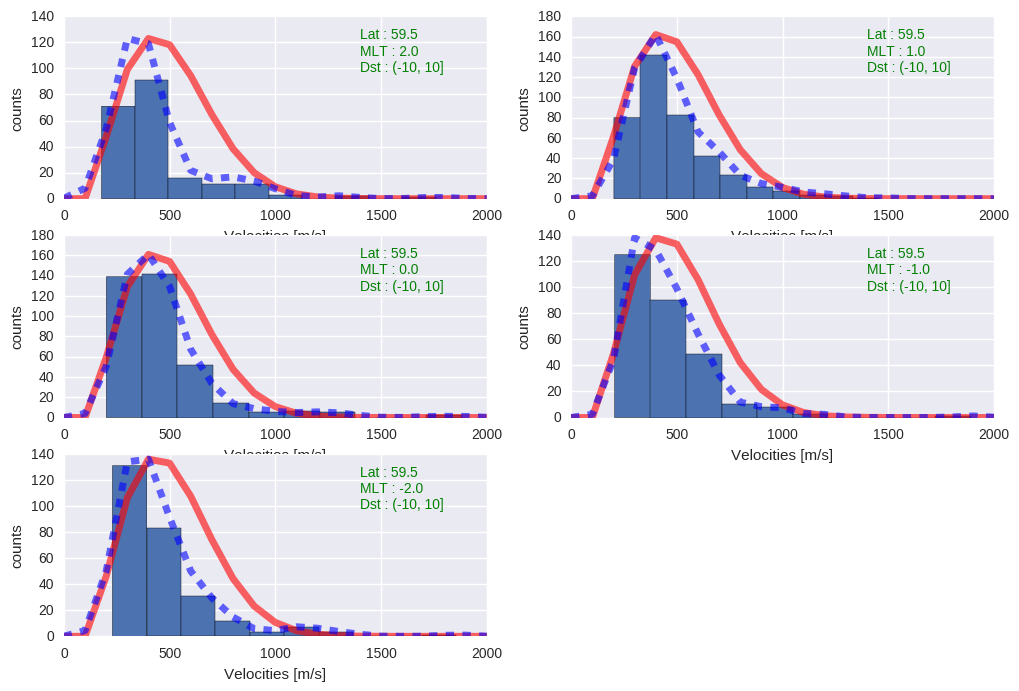

In [29]:
# Make a few plots of the fitting to get an estimate of how things are!
# Our velocities range from 0 to 2000 m/s
velsArr = numpy.arange(0.,2100.,100.)
selMLAT = 59.5#59.5#
selNormMLT = -3.#-3.#
selDstBin = "(-10, 10]"
selFitDF = fitRlgDF[ (fitRlgDF["dst_bin"] == selDstBin) &\
                (fitRlgDF["mlat"] == selMLAT) ]
selVelDF = velGmagDF[ (velGmagDF["dst_bin"] == selDstBin) & \
                  (velGmagDF["MLAT"] == selMLAT) ]
# get dst mean for the selected bin
dstMeanValCurrBin = velGmagDF[ (velGmagDF["dst_bin"] == selDstBin)\
                      ]["dst_index"].unique()[0]
f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,2,1) )
axArr.append( f.add_subplot(3,2,2) )
axArr.append( f.add_subplot(3,2,3) ) 
axArr.append( f.add_subplot(3,2,4) )
axArr.append( f.add_subplot(3,2,5) )
for ind, currNormMLT in enumerate( numpy.sort( selVelDF["normMLT"].unique() )[::-1] ):
    loc = selFitDF[ selFitDF["norm_mlt"] == currNormMLT ]["pred_loc"].tolist()[0]
    scale = selFitDF[ selFitDF["norm_mlt"] == currNormMLT ]["pred_scale"].tolist()[0]
    subVelDF = selVelDF[ selVelDF["normMLT"] == currNormMLT ]
    velScale = subVelDF["vSaps"].value_counts(bins=velsArr[::2]).max()
    pdf_fitted = scipy.stats.rayleigh.pdf(velsArr, loc=loc, scale=scale)
    meanVal = scipy.stats.rayleigh.mean(loc=loc, scale=scale)
    print "MLT, mean-->", currNormMLT, meanVal
    velKernel = scipy.stats.gaussian_kde( subVelDF["vSaps"], bw_method="scott" )
    pdf_adjusted = pdf_fitted/max(pdf_fitted) * velScale
    kernel_adjusted = (velKernel.pdf( velsArr )/max(velKernel.pdf( velsArr ))) * velScale
    axArr[ind].plot(velsArr, pdf_adjusted, 'r-', lw=5, alpha=0.6)
    axArr[ind].plot(velsArr, kernel_adjusted, 'b--', lw=5, alpha=0.6)
    axArr[ind].set_xlabel("Velocities [m/s]")
    axArr[ind].set_ylabel("counts")
    printText = "Lat : " + str(selMLAT) +\
                "\n" + "MLT : " + str(currNormMLT) +\
                "\n" + "Dst : " + selDstBin
    axArr[ind].text(0.7, 0.7,  printText,
            transform=axArr[ind].transAxes,
            color='green', fontsize=10)
    subVelDF["vSaps"].hist(ax=axArr[ind])
    axArr[ind].set_xlim( [0,2000] )
# plt.savefig("../figs/skewed-gaussian-fit-test.pdf",bbox_inches='tight')